<a href="https://colab.research.google.com/github/quanvu0996/TF_cert_training/blob/main/ML20M_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import psutil
# gives a single float value
print(psutil.cpu_percent())
# gives an object with many fields
print(psutil.virtual_memory())
# you can convert that object to a dictionary print(dict(psutil.virtual_memory()._asdict()))
# you can have the percentage of used RAM
print(psutil.virtual_memory().percent)
# you can calculate percentage of available memory
print(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)

23.0
svmem(total=13617737728, available=11884650496, percent=12.7, used=1549189120, free=10118561792, active=1892966400, inactive=1392902144, buffers=110166016, cached=1839820800, shared=1224704, slab=132153344)
12.7
87.27331024714533


In [3]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

In [4]:
tf.__version__

'2.8.0'

In [5]:
import gc
gc.collect()

147

In [6]:
itemCol = 'movieId'
userCol = 'userId'

In [7]:
# DGX setup
# fpath = "./ml-20m" 

#colab setup
from google.colab import drive
drive.mount('/content/gdrive')
fpath = "/content/gdrive/MyDrive/RECOMMENDER_STUDIES/data/ml-20m"

Mounted at /content/gdrive


In [8]:
ratings = pd.read_csv(fpath+'/ratings.csv')

In [9]:
ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


In [10]:
# Normalize rating về dạng -1 -> 1 (-1 = ghét, 1 = thích)
ratings["y"] = ratings["rating"]/2.5-1

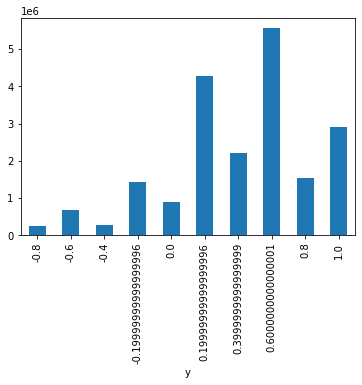

In [11]:
ratings.groupby("y")["y"].count().plot(kind='bar')

In [12]:
# Chia dữ liệu thành các tập cho model clustering, nhãn recommendation và test
#     Warm_up: các rating đã quan sát được từ người dùng (với các case predict)
#     Mask: rating bị che đi để model học phân cụm
#     target: rating dùng để đánh giá kết quả recommend của module recommend cho từng người dùng
# TODO: chia tập dữ liệu theo user-wise => đánh giá với những user hoàn toàn mới thì model có học được không?
# v2.1. gộp warm_up và mask thành 1
def dataset_split(ratings):
    train, test = train_test_split(ratings, test_size= 0.25)
    warm_up_mask, target = train_test_split(train, test_size= 0.25)
    return warm_up_mask, target, test

warm_up_mask, target, test = dataset_split(ratings)

In [13]:
warm_up_mask.shape[0], target.shape[0], test.shape[0]

(11250147, 3750050, 5000066)

### CLUSTERING MODEL
input: vocab of warm up item <br>
ouput: vocab of masked item

In [14]:
#TODO: bổ sung feature của item và feature của user => dựng hybrid model

In [15]:
# only keep top k popular item
# TODO: lấy top k item ntn?
# k= 1000
# top_items = ratings.groupby(itemCol).count().sort_values(by=userCol, ascending=False).head(k).index
# top_items

In [16]:
# Tổng hợp warm-up thành mảng theo user: mỗi user gồm chuỗi text danh sách mã item đã tương tác + ma trận rating
# def padding_series(series_item, wu_size, value=0, is_padding=True):
#     series_item1 = series_item.apply(lambda x: x[0:wu_size])
#     if is_padding:
#         series_item1 = series_item1.apply(lambda x: x+[value]*(wu_size-len(x)))
#     return series_item1

def padding_list(list_item, wu_size, value=0, is_padding=True):
    series_item1 = list_item[0:wu_size]
    if is_padding:
        series_item1 = series_item1+[value]*(wu_size-len(series_item1))
    return series_item1

def to_arr(series):
    x = series.apply(lambda x: np.array(x)).values
    return np.stack(x)

# v2.1: áp dụng padding cho ratings
def warm_up_str(warm_up, wu_size = 100, mask_size = 100, user_index=None):
    if user_index is not None:
        warm_up = warm_up[warm_up[userCol].isin(user_index)]

    # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
    rindex = warm_up.groupby(userCol)["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
    warm_up = warm_up.reindex(rindex)
    
    # Chuyển thành warm-up set theo từng user
    warm_up = warm_up.groupby("userId").agg({itemCol:list, "y":list})

    # # Giới hạn độ dài warm_up size
    # warm_up[itemCol] = warm_up[itemCol].apply(lambda x: x[0:wu_size])
    # warm_up["y"] = warm_up["y"].apply(lambda x: x[0:wu_size])

    # # Chuyển danh sách item về string để tái sử dụng layer xử lý text
    # warm_up[itemCol] = warm_up[itemCol].apply( lambda x: ' '.join(list([str(i) for i in x])))

    warm_up[itemCol] = warm_up[itemCol].apply(lambda x: train_test_split(x[0:(wu_size+mask_size)], test_size=0.25, random_state=42))
    warm_up["y"] = warm_up["y"].apply(lambda x: train_test_split(x[0:(wu_size+mask_size)], test_size=0.25, random_state=42))

    warm_up["warm_up_items"] = warm_up[itemCol].apply(lambda x:' '.join(list([str(i) for i in x[0]])))
    warm_up["warm_up_ratings"] = warm_up["y"].apply(lambda x: padding_list(x[0], wu_size ) )

    warm_up["masked_items"] = warm_up[itemCol].apply(lambda x:' '.join(list([str(i) for i in x[1]])))
    warm_up["masked_ratings"] = warm_up["y"].apply(lambda x: padding_list(x[1], mask_size ) )

    return warm_up

output_sequence_length= 100
mask_size = 100

wu_df = warm_up_str(warm_up_mask[warm_up_mask[userCol].isin([1,12,5, 11])]
                    , wu_size = output_sequence_length
                    , mask_size = 100)
wu_df

,movieId,y,warm_up_items,warm_up_ratings,masked_items,masked_ratings
userId,,,,,,
1,"[[4896, 4467, 3997, 5171, 1089, 653, 5039, 228...","[[0.6000000000000001, 0.6000000000000001, 0.39...",4896 4467 3997 5171 1089 653 5039 2288 2253 83...,"[0.6000000000000001, 0.6000000000000001, 0.399...",1750 1259 3030 3081 7482 593 1261 2872 293 715...,"[0.3999999999999999, 0.6000000000000001, 0.199..."
5,"[[1136, 377, 1036, 1097, 380, 1079, 60, 1196, ...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.199999999999...",1136 377 1036 1097 380 1079 60 1196 282 1080 3...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.1999999999999...",631 608 590 141 235 376 594 587 529 1393,"[0.19999999999999996, 0.19999999999999996, 1.0..."
11,"[[1097, 30812, 5459, 3438, 5266, 2600, 7022, 4...","[[0.8, 0.6000000000000001, 1.0, 0.8, 0.8, 1.0,...",1097 30812 5459 3438 5266 2600 7022 49278 5151...,"[0.8, 0.6000000000000001, 1.0, 0.8, 0.8, 1.0, ...",48516 6365 64997 54995 7173 1876 4226 3980 828...,"[0.8, 1.0, 1.0, 0.6000000000000001, 0.8, 0.8, ..."
12,"[[590, 17, 589, 595, 3, 480, 7, 648, 1, 653, 5...","[[0.19999999999999996, 0.19999999999999996, 0....",590 17 589 595 3 480 7 648 1 653 5 260 380 736...,"[0.19999999999999996, 0.19999999999999996, 0.6...",527 494 784 36 95 104,"[0.6000000000000001, 0.19999999999999996, 0.60..."


* Warm_up_items và mask_items chuyển về dạng text => sẽ sử dụng TextVectorizer để encode (tokenizer) và padding (bao gồm cả việc giới hạn độ dài chuỗi cho khớp với độ dài của ratings)
* Với warm_up_ratings và mask_ratings chưa tìm ra cách dựng layer như TextVectorization => chạy padding thủ công tiền xử lý thành array trước

In [17]:
# Shape (n_user, wu_size)
warm_up_ratings = np.stack(wu_df["warm_up_ratings"])

# Shape (n_user, mask_size)
masked_ratings = np.stack(wu_df["masked_ratings"])

In [18]:
warm_up_ratings.shape , masked_ratings.shape

((4, 100), (4, 100))

In [19]:
wu_df.apply(lambda x: len(x["masked_items"].split(" ")), axis=1)

userId
1     25
5     10
11    50
12     6
dtype: int64

### Xây dựng encoder model
Encoder =  interaction embedding + user feature embedding<br> 
interaction embedding = sum( interaction embedding các item i)<br> 
interaction embedding item i = rating x (embedding id sản phẩm + embedding item feature)<br>



In [20]:
max_vocab_size = 5000

vectorizer = layers.TextVectorization( max_tokens=max_vocab_size, split='whitespace', output_sequence_length= output_sequence_length, name = 'vectorizer')
vectorizer.adapt( wu_df["warm_up_items"] )

vectorizer(wu_df["warm_up_items"]).shape

TensorShape([4, 100])

#### Interaction model
Nhận vào text (gồm các mã id sản phẩm) và ratings => chuyển thành vector theo từng user <br>
Nếu không có user demographic thì interaction embedding là encoder model

In [76]:
# Xây dựng mạng
wu_size = 100
embedding_size = 100
reps_size = 50

def interaction_embedding():

    input_wi = layers.Input(shape=(1,), name='input_wi')
    wi = vectorizer(input_wi)
    wi = layers.Embedding(input_dim= max_vocab_size, output_dim= embedding_size, mask_zero= True, name='ei')(wi)
    wi = layers.Dense(embedding_size, activation='relu', name='di')(wi)

    wr = layers.Input(shape=(100,), name='warm_up_ratings')

    ireps = layers.Multiply(name='mul')([wi, wr])
    uprofile = layers.Lambda(lambda z: K.sum(z, axis=1), name='lambda')(ireps)

    ureps = layers.LayerNormalization(name='norm')(uprofile)
    ureps = layers.Dense( reps_size, activation='relu', name='du')(ureps)
    
    model = tf.keras.Model(inputs= [input_wi, wr], outputs=[ureps])
    return model

encode_model = interaction_embedding()

In [77]:
encode_model.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_wi (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 vectorizer (TextVectorization)  (None, 100)         0           ['input_wi[0][0]']               
                                                                                                  
 ei (Embedding)                 (None, 100, 100)     500000      ['vectorizer[15][0]']            
                                                                                                  
 di (Dense)                     (None, 100, 100)     10100       ['ei[0][0]']                     
                                                                                           

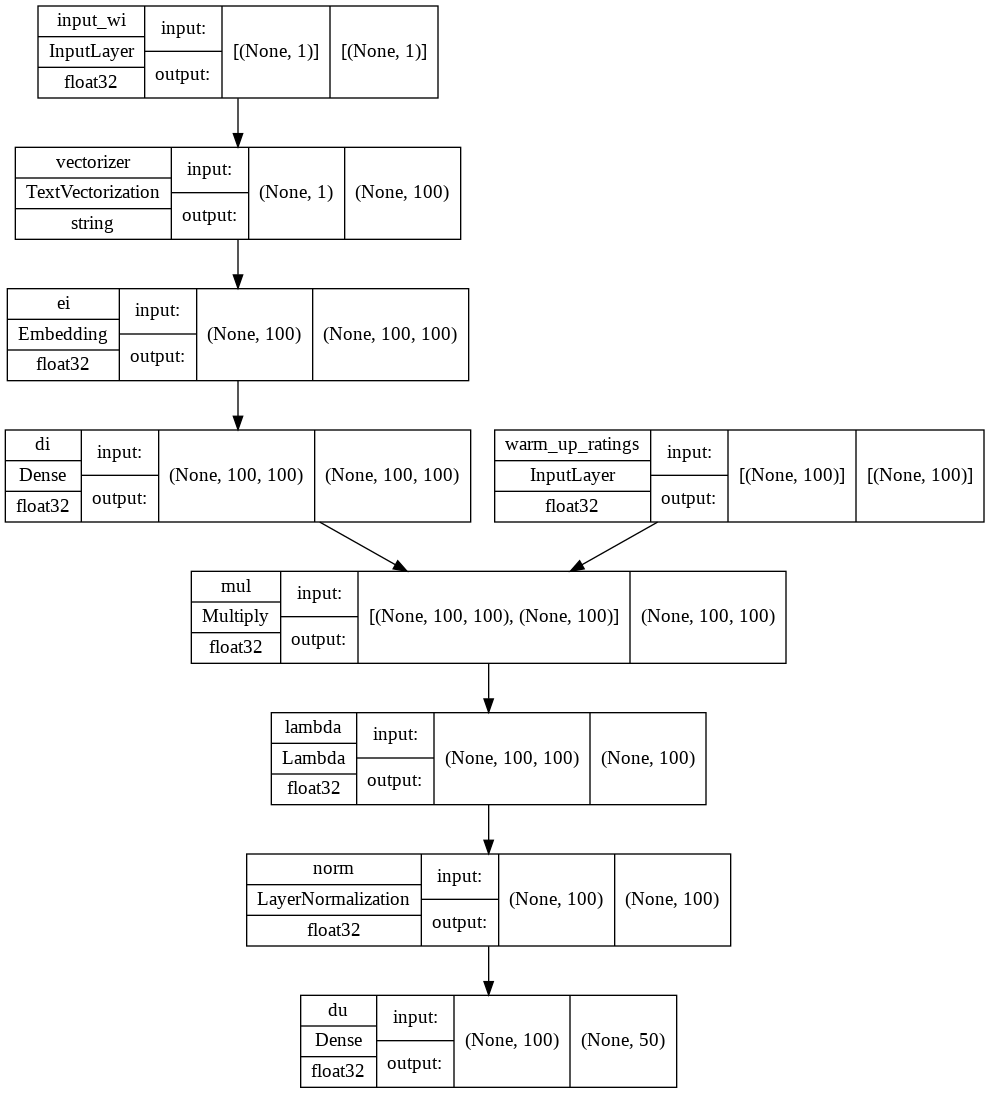

In [78]:
tf.keras.utils.plot_model( encode_model ,show_shapes=True, show_dtype=True, show_layer_names=True )

#### Decoder model
Nhận vào text (gồm các mã id sản phẩm) và ratings => chuyển thành vector theo từng user <br>
Sử dụng chính interaction embedding encoder để chuyển mask interaction thành vector => thu được y_true, cho model 


In [79]:
# Xây dựng mạng
def mask_label():

    input_mi = layers.Input(shape=(1,), name='input_mask')
    mi = encode_model.get_layer('vectorizer')(input_mi)
    mi = encode_model.get_layer('ei')(mi)

    mr = layers.Input(shape=(100,), name='mask_rating')

    ireps = layers.Multiply(name='mul')([mi, mr])
    uprofile = layers.Lambda(lambda z: K.sum(z, axis=1), name='lambda')(ireps)
    ureps = layers.LayerNormalization(name='norm')(uprofile)
    
    model = tf.keras.Model(inputs= [input_mi, mr], outputs=[ureps])
    return model

dencode_model = mask_label()

In [80]:
dencode_model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 vectorizer (TextVectorization)  (None, 100)         0           ['input_mask[0][0]']             
                                                                                                  
 ei (Embedding)                 (None, 100, 100)     500000      ['vectorizer[16][0]']            
                                                                                                  
 mask_rating (InputLayer)       [(None, 100)]        0           []                               
                                                                                           

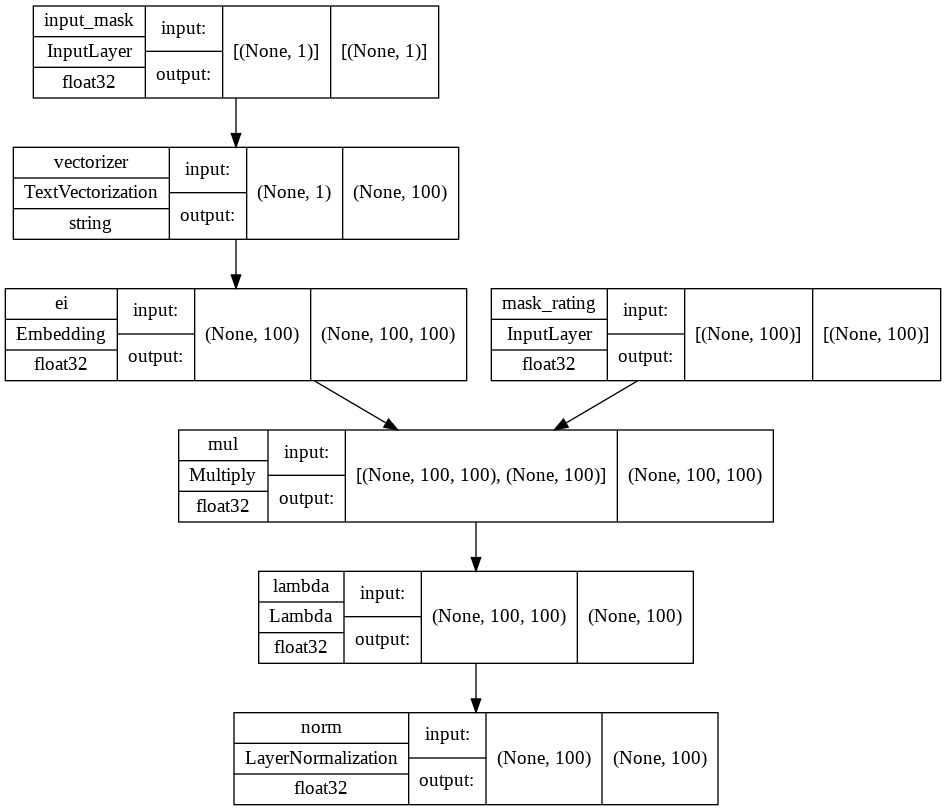

In [81]:
tf.keras.utils.plot_model( dencode_model ,show_shapes=True, show_dtype=True, show_layer_names=True )

Clustering model

In [82]:
cluster_num = 50

def get_clustering_model():

    input_clustering = layers.Input(shape=(reps_size), name='input_clustering')
    wi = layers.Dense(cluster_num, activation='sigmoid', name='clustering')(input_clustering)
    wi = layers.Dense(mask_size, activation = 'relu') (wi)
    
    model = tf.keras.Model(inputs= [input_clustering], outputs=[wi])
    return model

clustering_model = get_clustering_model()

In [83]:
class Efficient_Rec(tf.keras.Model):
  def __init__(self, use_tf_function=False):
    super().__init__()
    self.use_tf_function = use_tf_function
    
    # Build the encoder and decoder
    encoder = interaction_embedding()
    clustering = get_clustering_model()
    decoder = mask_label()

    self.encoder = encoder
    self.decoder = decoder
    self.clustering = clustering

  def train_step(self, inputs):
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

Tiền xử lý:
1. Nhận vào một batch gồm items (n_user, ) và ratings (n_user, )
2. Tách items thành warm_up items và mask items, tương ứng tách ratings thành warm_up ratings và mask ratings
3. Chạy Vectorizer chuyển items và ratings về dạng list có cùng chiều
4. Chuyển list item đã mã hóa thành vector

In [84]:
# TODO: dựng preprocess function để xử lý tách warm_up, mask
# def _preprocess(self, input_items, input_ratings):
#   self.shape_checker(input_text, ('batch',))
#   self.shape_checker(target_text, ('batch',))

#   # Convert the text to token IDs
#   input_tokens = self.input_text_processor(input_text)
#   target_tokens = self.output_text_processor(target_text)
#   self.shape_checker(input_tokens, ('batch', 's'))
#   self.shape_checker(target_tokens, ('batch', 't'))

#   # Convert IDs to masks.
#   input_mask = input_tokens != 0
#   self.shape_checker(input_mask, ('batch', 's'))

#   target_mask = target_tokens != 0
#   self.shape_checker(target_mask, ('batch', 't'))

#   return input_tokens, input_mask, target_tokens, target_mask
# Efficient_Rec._preprocess = _preprocess

In [99]:
def _train_step(self, inputs):
  wu_items, wu_ratings, mask_item, mask_ratings = inputs  

  with tf.GradientTape() as tape:
    # Encode the input
    wu_vec = self.encoder([wu_items, wu_ratings])
    cluster_output = self.clustering(wu_vec)

    # Encde the output
    mask_vec = self.decoder([mask_item, mask_ratings])

    average_loss = self.loss(mask_vec, cluster_output)

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

Efficient_Rec._train_step = _train_step

In [105]:
# @tf.function()
# def _tf_train_step(self, inputs):
#   return self._train_step(inputs)

# Efficient_Rec._tf_train_step = _tf_train_step

In [107]:
model = Efficient_Rec( use_tf_function=False)

# Configure the loss and optimizer
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
)

In [108]:
%%time
for n in range(20):
  print(model.train_step([wu_df["warm_up_items"], warm_up_ratings, wu_df["masked_items"], masked_ratings]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.4065861>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.37265843>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.34762824>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.32587278>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.3093509>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.29599702>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.28477454>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.27508694>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.2666593>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.25963452>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.25304556>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.24671324>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.24094936>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.23531792>}
{'batch_l

In [115]:
model.clustering(model.encoder([wu_df["warm_up_items"], warm_up_ratings]))

<tf.Tensor: shape=(4, 100), dtype=float32, numpy=
array([[2.37496555e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.78408855e-01, 3.03335667e-01, 1.47825789e+00, 3.78893971e-01,
        0.00000000e+00, 0.00000000e+00, 2.51545310e-01, 7.18147904e-02,
        0.00000000e+00, 3.32544804e-01, 8.44972134e-02, 2.82700241e-01,
        1.66055575e-01, 0.00000000e+00, 6.62790000e-01, 5.05590975e-01,
        1.90221146e-01, 4.91439968e-01, 0.00000000e+00, 0.00000000e+00,
        3.91027898e-01, 0.00000000e+00, 0.00000000e+00, 1.31224632e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.46679578e-02, 2.75374111e-02,
        0.00000000e+00, 5.20200692e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.71607020e-02,
        0.0000

# Code cũ v1.0
Cố gắng dựng padding layer: bao gồm bước padding, xử lý ratings trong model => không cần tiền xử lý

In [70]:
def padding(sequence, output_sequence_length):
    if len(sequence) > output_sequence_length:
        sequence = sequence[:output_sequence_length]
    t = tf.constant(sequence, dtype=np.float32)
    p = tf.zeros(output_sequence_length-t.shape[0])
    return K.concatenate([t, p], axis=0)

class PaddingLayers(keras.engine.base_preprocessing_layer.PreprocessingLayer):
    def __init__(self, output_sequence_length, **kwargs):
        super().__init__(**kwargs)
        self.output_sequence_length = output_sequence_length

    def compute_output_shape(self, input_shape):
        return tf.TensorShape([self.output_sequence_length])

    def compute_output_signature(self, input_spec):
        output_shape = self.compute_output_shape(input_spec.shape.as_list())
        output_dtype = tf.float32
        return tf.TensorSpec(shape=output_shape, dtype=output_dtype)

    def call(self, inputs):
        ts = []
        for s in inputs:
            ts.append(padding(s, self.output_sequence_length))

        return tf.stack(ts, axis=0)

# Test layer
paddinglayer = PaddingLayers(output_sequence_length= output_sequence_length)
paddinglayer(wu_df["warm_up_ratings"]).shape

TensorShape([4, 100])

In [72]:
output_sequence_length

100

In [71]:
# Xây dựng mạng
wu_size = 100
embedding_size = 100
cluster_num = 50


def get_model():

    input_wi = layers.Input(shape=(1,), name='input_wi')
    wi = vectorizer(input_wi)
    wi = layers.Embedding(input_dim=output_sequence_length, output_dim= embedding_size, mask_zero= True, name='ei')(wi)
    wi = layers.Dense(embedding_size, activation='relu', name='di')(wi)

    input_wr = layers.Input(shape=(1,), name='input_wr')
    wr = PaddingLayers(output_sequence_length= output_sequence_length)(input_wr)

    ireps = layers.Multiply(name='mul')([wi, wr])
    uprofile = layers.Lambda(lambda z: K.sum(z, axis=1), name='lambda')(ireps)

    ureps = layers.LayerNormalization(name='norm')(uprofile)
    ureps = layers.Dense(int(wu_size/2), activation='relu', name='du')(ureps)
    clusters = layers.Dense(cluster_num, activation= 'sigmoid', name='clustering')(ureps)
    mask = layers.Dense(corrector_size)(clusters)
    
    model = tf.keras.Model(inputs= [input_wi, input_wr], outputs=[wi])
    return model

model = get_model()

TypeError: ignored

In [264]:
wi

<KerasTensor: shape=(None, 100, 100) dtype=float32 (created by layer 'di')>

In [231]:
vectorizer(wu_df["warm_up_items"].values[0:1])

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[231, 216,   6,   8, 161, 193, 194, 225,  72, 131, 167, 181, 203,
         36, 182, 217,  12, 219,  81, 165, 180, 130,  27, 172, 201, 211,
         97,   4, 171,  33, 190,  17, 169,  77, 151, 235, 226,  44, 160,
         93, 229, 173, 192, 202,   9, 152,  37,  66,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]])>

# << OLD CODE>>

In [227]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, inputs, state=None):
    tokens, weights = inputs

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    

    # 4. Returns the new sequence and its state.
    return output, state

userId
1     1198 1387 589 2959 31696 2193 2140 1222 5797 4...
5     1042 380 140 62 457 589 1080 1035 608 11 104 3...
11    1917 31555 968 52287 51666 2291 595 6016 56949...
12      208 494 590 17 786 36 5 364 648 784 733 780 788
Name: warm_up_items, dtype: object

In [19]:
%%time
# Tổng hợp warm-up thành mảng theo user: mỗi user gồm một ma trận item_id + rating của item đó
# TODO: v2: sửa lại chỉ concat warmup lại thành chuỗi cách nhau bởi dấu cách => sử dụng textvectorizer (không phải encode + padding)

def padding_list(series_item, wu_size, value=0, is_padding=True):
    series_item1 = series_item.apply(lambda x: x[0:wu_size])
    if is_padding:
        series_item1 = series_item1.apply(lambda x: x+[value]*(wu_size-len(x)))
    return series_item1

def to_arr(series):
    x = series.apply(lambda x: np.array(x)).values
    return np.stack(x)
    
def warmup_arr(warm_up, wu_size = 100, user_index=None, items = None, is_padding = True):
    if user_index is not None:
        warm_up = warm_up[warm_up["userId"].isin(user_index)]

    if items is not None:
        warm_up = warm_up[warm_up[itemCol].isin(items)]

    
    # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
    rindex = warm_up.groupby("userId")["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
    warm_up = warm_up.reindex(rindex)
    
    # Chuyển thành warm-up set theo từng user
    warm_up = warm_up.groupby("userId").agg({itemCol:list, "y":list})
    
    # Cắt và padding để có chung độ dài
    warm_up["movieId_pad"] = padding_list(warm_up[itemCol], wu_size, is_padding=is_padding)
    warm_up["rating_pad"] = padding_list(warm_up["y"], wu_size, is_padding=is_padding)
    
#     warm_up["length"] = warm_up["movieId_pad"].apply(lambda x: len(x))
    if user_index is not None:
        warm_up = warm_up.reindex(user_index)
    
    if not is_padding:
        return warm_up#warm_up["movieId_pad"], warm_up["rating_pad"], warm_up.index
    
    # Chuyển về array
    items_arr = to_arr(warm_up["movieId_pad"])
    ratings = to_arr(warm_up["rating_pad"])
    user_index = warm_up.index
    
    return items_arr, ratings, user_index

# item_arr, rating_arr, user_index = warmup_arr(warm_up[warm_up["userId"].isin([11, 12, 103, 16, 20])])
item_arr, rating_arr, user_index = warmup_arr(warm_up, wu_size=100, items=top_items)

done 1
done 2


In [15]:
# Tổng hợp warm-up thành mảng theo user: mỗi user gồm một ma trận item_id + rating của item đó

def padding_list(series_item, wu_size, value=0, is_padding=True):
    series_item1 = series_item.apply(lambda x: x[0:wu_size])
    if is_padding:
        series_item1 = series_item1.apply(lambda x: x+[value]*(wu_size-len(x)))
    return series_item1

def to_arr(series):
    x = series.apply(lambda x: np.array(x)).values
    return np.stack(x)
    
def warmup_arr(warm_up, wu_size = 100, user_index=None, items = None, is_padding = True):
    if user_index is not None:
        warm_up = warm_up[warm_up["userId"].isin(user_index)]
    if items is not None:
        warm_up = warm_up[warm_up["i"].isin(items)]
    
    # Sắp xếp item theo thứ tự giảm dần rating (về sau cắt padding sẽ ưu tiên giữ lại item có rating cao)
    rindex = warm_up.groupby("userId")["y"].transform(lambda grp: grp.sort_values(ascending=False).index)
    warm_up = warm_up.reindex(rindex)
    
    # Chuyển thành warm-up set theo từng user
    warm_up = warm_up.groupby("userId").agg({"i":list, "y":list})
    
    # Cắt và padding để có chung độ dài
    warm_up["movieId_pad"] = padding_list(warm_up["i"], wu_size, is_padding=is_padding)
    warm_up["rating_pad"] = padding_list(warm_up["y"], wu_size, is_padding=is_padding)
    
#     warm_up["length"] = warm_up["movieId_pad"].apply(lambda x: len(x))
    if user_index is not None:
        warm_up = warm_up.reindex(user_index)
    
    if not is_padding:
        return warm_up#warm_up["movieId_pad"], warm_up["rating_pad"], warm_up.index
    
    # Chuyển về array
    items_arr = to_arr(warm_up["movieId_pad"])
    ratings = to_arr(warm_up["rating_pad"])
    user_index = warm_up.index
    
    return items_arr, ratings, user_index

# item_arr, rating_arr, user_index = warmup_arr(warm_up[warm_up["userId"].isin([11, 12, 103, 16, 20])])
item_arr, rating_arr, user_index = warmup_arr(warm_up, items=top_items)

KeyError: ignored

In [ ]:
def sequence_to_vect(items, ratings, size):
    vect = np.zeros([size], dtype=np.float16)
    if items == items:
        vect[items] = ratings
    return vect
            

In [ ]:
def get_corrector(corrector, user_index, corrector_size):
    corr_df = warmup_arr( corrector, user_index = user_index, is_padding=False)
    corr_df["vect"] = corr_df.apply(lambda x: sequence_to_vect(x["movieId_pad"], x["rating_pad"], corrector_size)
                                    , axis=1)
    return to_arr(corr_df["vect"]), corr_df.index

corrector_size = k+1
corrector_arr, corr_index = get_corrector(corrector, user_index, corrector_size)

In [ ]:
# Kiểm tra data đầu vào và đầu ra khớp nhau
corr_index.shape == user_index.shape

True

In [ ]:
gc.collect()

399

In [ ]:
def Focus2(alpha=0.01):
    def cal_los(y_true, y_pred):
        y_pred = tf.cast(y_pred, tf.float32)
        y_true = tf.cast(y_true, tf.float32)

        positive_true = y_true[y_true!=0]
        positive_pred = y_pred[y_true!=0]
        los1 = K.square(positive_true-positive_pred )

        zero_true = y_true[y_true==0]
        zero_pred = y_pred[y_true==0]
        los2 =alpha*  K.square(zero_true-zero_pred )


        return K.mean( tf.concat([los1, los2], axis=0) )
    return cal_los

y_true = tf.constant([1,0.2,0,1])
y_pred = tf.constant([1,0,5.2,1.005])

Focus2(0.01)(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.07760624>

In [ ]:
# def Focus2(alpha=0.01):
#     def cal_los(y_true, y_pred):
#         y_pred = tf.cast(y_pred, tf.float32)
#         y_true = tf.cast(y_true, tf.float32)

#         positive_true = y_true[y_true!=0]
#         positive_pred = y_pred[y_true!=0]
#         los1 = K.square(positive_true-positive_pred )
#         w1 = tf.ones(positive_true.shape[0])

#         zero_true = y_true[y_true==0]
#         zero_pred = y_pred[y_true==0]
#         los2 = alpha*  K.square(zero_true-zero_pred )
#         w2 = alpha* tf.ones(zero_true.shape[0])

#         return K.sum(tf.multiply( tf.concat([los1, los2], axis=0), tf.concat([w1, w2], axis=0) ))
#     return cal_los

# y_true = tf.constant([1,0.2,0.4,1])
# y_pred = tf.constant([1,0.2,0.4,1.1])

# Focus2(0.001)(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.010000004>

In [ ]:
# Xây dựng mạng
# def single_itemId(i,input_dim, embedding_size):
#     x = layers.Input(name='input'+i )
#     x = layers.Embedding(input_dim=input_dim, output_dim= embedding_size, mask_zero= True)(x)
#     return x
wu_size = 100
embedding_size = 100
input_dim = item_num
cluster_num = 50

def get_model():

    input_wi = layers.Input(shape=(wu_size), name='warmup_item')
    wi = layers.Embedding(input_dim=input_dim, output_dim= embedding_size, mask_zero= True, name='ei')(input_wi)
    wi = layers.Dense(embedding_size, activation='relu', name='di')(wi)

    wr = layers.Input(shape=(wu_size), name='warmup_rating')

    ireps = layers.Multiply(name='mul')([wi, wr])
    uprofile = layers.Lambda(lambda z: K.sum(z, axis=1), name='lambda')(ireps)

    ureps = layers.LayerNormalization(name='norm')(uprofile)
    ureps = layers.Dense(int(wu_size/2), activation='relu', name='du')(ureps)
    clusters = layers.Dense(cluster_num, activation= 'sigmoid', name='clustering')(ureps)
    correctors = layers.Dense(corrector_size)(clusters)
    
    model = tf.keras.Model(inputs= [input_wi, wr], outputs=[correctors])
    return model

model = get_model()

In [ ]:
model.compile( optimizer='adam', loss= Focus2(1e-5) )

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 warmup_item (InputLayer)       [(None, 100)]        0           []                               
                                                                                                  
 ei (Embedding)                 (None, 100, 100)     100000      ['warmup_item[0][0]']            
                                                                                                  
 di (Dense)                     (None, 100, 100)     10100       ['ei[0][0]']                     
                                                                                                  
 warmup_rating (InputLayer)     [(None, 100)]        0           []                               
                                                                                            

In [ ]:
model.fit(x=[item_arr, rating_arr], y=corrector_arr, epochs=5, batch_size=512)

Epoch 1/5
261/261 [==============================] - 38s 142ms/step - loss: 8.0480e-04
Epoch 2/5
261/261 [==============================] - 38s 147ms/step - loss: 4.6183e-04
Epoch 3/5
261/261 [==============================] - 38s 145ms/step - loss: 4.4639e-04
Epoch 4/5
261/261 [==============================] - 38s 147ms/step - loss: 4.4143e-04
Epoch 5/5
261/261 [==============================] - 38s 144ms/step - loss: 4.3835e-04


In [ ]:
input_wi = model.get_layer('warmup_item')
wi = model.get_layer('ei')(input_wi)

AttributeError: ignored

In [ ]:
def get_cluster_model(model):
    input_wi = model.get_layer('warmup_item')
    wi = model.get_layer('ei')(input_wi)
    wi = model.get_layer('di')(wi)

    wr = model.get_layer('warmup_rating')

    ireps = model.get_layer('mul')([wi, wr])
    uprofile = model.get_layer('lambda')(ireps)

    ureps = model.get_layer('norm')(uprofile)
    ureps = model.get_layer('du')(ureps)
    clusters = model.get_layer('clustering')(ureps)

    cluster_model = tf.keras.Model(inputs= [input_wi, wr], outputs=[clusters])
    return cluster_model

cluster_model = get_cluster_model(model)

AttributeError: ignored

In [ ]:
rating_arr[0]

array([0.9, 0.8, 0.8, 0.8, 0.8, 0.7, 0.7, 0.7, 0.6, 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [ ]:
corrector_arr.shape

(133338, 1001)

### OLD VERSION (deep co-clustering)

In [ ]:
# ts_corrector = tf.sparse.SparseTensor( 
#     indices= np.concatenate([np.expand_dims(corrector["i"].values, -1), np.ones((2812537, 1))], axis=1),
#     values = corrector["y"], 
#     dense_shape= (corrector.shape[0],item_num) )

In [ ]:
def user_wise_split(df, userCol, itemCol, test_size=0.25):
    all_user = df[userCol].drop_duplicates()
    train_user, test_user = train_test_split(all_user, test_size=test_size)

    train_ratings = df[df[itemCol].isin(train_user)]
    test_ratings = df[df[itemCol].isin(test_user)]
    return train_ratings, test_ratings

train_val, test = train_test_split(ratings, test_size= 0.25)
train, valid = user_wise_split(train_val,userCol, itemCol, test_size=0.25 )
train.head()

In [ ]:
train["y"] = train["rating"]/5
u_encoder = sklearn.preprocessing.LabelEncoder()
i_encoder = sklearn.preprocessing.LabelEncoder()

train["u"] = u_encoder.fit_transform(train[[userCol]])
train["i"] = i_encoder.fit_transform(train[[itemCol]])

In [ ]:
u_num = ratings[userCol].drop_duplicates().count()
i_num = ratings[itemCol].drop_duplicates().count()

u_embedding_size = 50
i_embedding_size = 100

u_clusters = 100
i_clusters = 50

embedding_size = 100

# user
u_input = layers.Input(shape=(1,), name="input_u")
u = layers.Embedding( input_dim= u_num, output_dim= u_embedding_size, name="embedding_u")(u_input)
u = layers.Dense( u_clusters, activation= 'sigmoid', name="sigmoid_u" )(u)
u = layers.Dense( embedding_size, activation= 'relu', name="resize_u" )(u)
u = layers.Reshape( target_shape=(embedding_size,), name="reshape_u")(u)

# item
i_input = layers.Input(shape=(1,), name="input_i")
i = layers.Embedding( input_dim= i_num, output_dim= i_embedding_size, name="embedding_i")(i_input)
i = layers.Dense( i_clusters, activation= 'sigmoid', name="sigmoid_i" )(i)
i = layers.Dense( embedding_size, activation= 'relu', name="resize_i")(i)
i = layers.Reshape( target_shape=(embedding_size,), name="reshape_i")(i)

dot = layers.Dot(normalize= True, axes=1, name="dot")([u, i])
out = layers.Dense( units=1, activation='linear', name="out")(dot)

# compile
model = tf.keras.models.Model(inputs= [u_input, i_input], outputs= out )
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

In [ ]:
train

In [ ]:
# train
training = model.fit(x=[train["u"], train["i"]], y=train["y"], 
                     epochs=3, batch_size=1024*10, shuffle=True, verbose=1, validation_split=0.3)

In [ ]:
# user clustering
uCluster = tf.keras.Sequential([
    model.get_layer("input_u"), 
    model.get_layer("embedding_u"), 
    model.get_layer("sigmoid_u"), 
    ]
)

# user clustering
iCluster = tf.keras.Sequential([
    model.get_layer("input_i"), 
    model.get_layer("embedding_i"), 
    model.get_layer("sigmoid_i"), 
    ]
)

In [ ]:
np.argmax( uCluster(np.array([98818, 36868]))[1][0] )

In [ ]:
np.argmax( iCluster(np.array([1360, 1009])).numpy().reshape(2,50) , axis=1)

In [ ]:
iCluster(np.array([1360, 1009]))